# (9주차) 5월2일 (2) -- draft
> 확률적 경사하강법, 
- toc:true
- branch: master
- badges: true
- comments: true
- author: 최규빈

## 강의영상 

## import

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import tensorflow.experimental.numpy as tnp

In [2]:
tf.config.experimental.list_physical_devices()

2022-05-02 19:36:54.060328: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 19:36:54.079101: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 19:36:54.079539: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
import graphviz
def gv(s): return graphviz.Source('digraph G{ rankdir="LR"'+ s + ';}')

## 중간고사 관련 잡담 

- 2번의 경우 왜 잘 안 나오냐면, gradient가 한 쪽만 강해서. loss function 형태를 봐보자!(이론적으로는 convex하지만 실질적으로 수렴시키는게 힘든 구조

### 중간고사 3번문제

- 유의한 coefficient(basis) 4개, 그런데 우리는 6개 basis(basis가 있으면 어떤 Y든 만들 수 있다) 사용 -> 과적합일까?
- 과적합을 판단하는 방법 : training, test loss를 구해서 비교하기
- (!) 회귀분석은 과적합이 안된다 : N이 커질수록 필요없는 coefficient가 0으로 가서 그렇다. 그래서 회귀분석은 유의성 검정을 한다.(0인지 아닌지를 검정한다)

- 과적합은 변수가 많아진다고 항상 일어나는 것이 아니다! -> semiparametric regression

`-` 특이한모형: 오버핏이 일어날 수 없는 모형이다. 
- 유의미한 coef: 상수항(bias), $\cos(t)$의 계수, $\cos(2t)$의 계수, $\cos(5t)$의 계수. 
- 유의미하지 않은 coef: $\cos(3t)$의 계수, $\cos(4t)$의 계수 
- 유의미하지 않은 계수는 $n%$이 커질수록 0으로 추정된다 =  $\cos(3t)$와 $\cos(5t)$는 사용자가 임의로 제외하지 않아도 결국 모형에서 알아서 제거된다 = overfit이 일어나지 않는다. 모형이 알아서 유의미한 변수만 뽑아서 fit하는 느낌

`-` 3번문제는 overfit이 일어나지 않는다. 이러한 신기한 일이 일어나는 이유는 모든 설명변수가 직교하기 때문임. 
- 이런 모형의 장점: overfit이 일어날 위험이 없으므로 train/test로 나누어 학습할 이유가 없다. (샘플만 버리는 꼴, test에 빼둔 observation까지 모아서 학습해 $\beta$를 좀 더 정확히 추론하는게 차라리 더 이득) 
- 이러한 모형에서 할일: 추정된 계수들이 0인지 아닌지만 test하면 된다. (이것을 유의성검정이라고 한다) 

`-` 직교기저의 예시 
- 빨강과 파랑을 255,255만큼 섞으면 보라색이 된다. 
- 빨강과 파랑과 노랑을 각각 255,255,255만큼 섞으면 검은색이 된다. 
- 임의의 어떠한 색도 빨강,파랑,노랑의 조합으로 표현가능하다. 즉 $\text{color}= \text{red}*\beta_1 + \text{blue}*\beta_2 + \text{yellow}*\beta_3$ 이다. 
- (빨,파,노)는 색을 표현하는 basis이다. (적절한 $\beta_1,\beta_2,\beta_3$을 구하기만 하면 임의의 색도 표현가능)
- (빨,보,노)역시 색을 표현하는 basis라 볼 수 있다. (파란색이 필요할때 보라색-빨간색을 하면되니까) 
- (빨,보,검)역시 색을 표현하는 basis라 볼 수 있다. (파란색이 필요하면 보라색-빨간색을 하면되고, 노란색이 필요하면 검정색-보라색을 하면 되니까)
- (빨,파,노)는 직교기저이다. 

`-` 3번에서 알아둘 것: (1) 직교기저의 개념 (추후 재설명) (2) 임의의 색을 표현하려면 3개의 basis가 필요함 

### 중간고사 1-(3)번 문제

`-` 그림을 그려보자. 

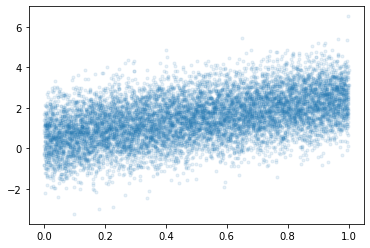

In [5]:
_x= tf.constant(np.arange(1,10001)/10000)
_y= tnp.random.randn(10000) + (0.5 + 2*_x) 
plt.plot(_x,_y,'.',alpha=0.1)

`-` 저것 꼭 10000개 다 모아서 loss계산해야할까? 

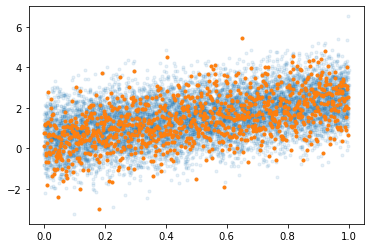

In [7]:
plt.plot(_x,_y,'.',alpha=0.1)
plt.plot(_x[::10],_y[::10],'.')  #간격을 10씩 이동한 sample이 추출됨

`-` 대충 이정도만 모아서 해도 비슷하지 않을까? $\to$ 해보자!$\to$ 확률적경사하강법을 배우자!

## 경사하강법과 확률적경사하강법

`-` 단순회귀분석에서 10개의 샘플 관측 : $\{(x_i,y_i)\}_{i=1}^{10}$

### ver1: 모든 샘플을 사용하여 slope계산

(epoch1) $loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) $loss=\sum_{i=1}^{10}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$

...

$\to$ gradient descent

$\to$ epoch은 샘플을 모두 돌아야 1번

### ver2: 하나의 샘플만 사용하여 slope계산 

(epoch1) 
- $loss=(y_1-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_2-\beta_0-\beta_1x_2)^2 \quad \to \quad slope \quad \to \quad update$
- ...
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) 
- $loss=(y_1-\beta_0-\beta_1x_1)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_2-\beta_0-\beta_1x_2)^2 \quad \to \quad slope \quad \to \quad update$
- ...
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

...

$\to$ 

ver1은 질로 승부, ver2는 양으로 승부

### ver3: $m(\leq n)$개의 샘플만 사용하여 slope계산

$m=3$이라고 하자. 

(epoch1) 
- $loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

(epoch2) 
- $loss=\sum_{i=1}^{3}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=4}^{6}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=\sum_{i=7}^{9}(y_i-\beta_0-\beta_1x_i)^2 \quad \to \quad slope \quad \to \quad update$
- $loss=(y_{10}-\beta_0-\beta_1x_{10})^2 \quad \to \quad slope \quad \to \quad update$

...

전체배치에서 미니배치(m)만큼 모아서 업데이트를 진행 $\to$ n을 어떻게 선택하냐에 따라 1도 되고 2도 되는..만능 버젼

### 용어의 정리 

#### 옛날 (좀 더 엄밀)

`-` ver1: gradient descent, batch gradient descent 


`-` ver2: stochastic gradient descent(확률적 경사하강법)

`-` ver3: mini-batch gradient descent, mini-batch stochastic gradient descent

#### 요즘 

`-` ver1: gradient descent


`-` ver2: stochastic gradient descent with batch size = 1 

`-` **ver3: stochastic gradient descent** 
- https://www.deeplearningbook.org/contents/optimization.html, 알고리즘 8-1 참고. 

note: 이렇게 많이 쓰는 이유? ver1,2는 사실상 없는 방법이므로

### ver1,2,3 이외에 좀 더 지저분한 것들이 있다. 

`-` ver2,3에서 샘플을 셔플할 수도 있다.

`-` ver3에서 일부 샘플이 학습에 참여 안하는 버전도 있다.  : 공평하게 업데이트가 이루어지도록 혼자 남는 10번째 샘플을 섞어준다.  
`-` 그런데 n이 커지면 알아서 잘 가기 때문에... 

`-` 개인적 생각: 크게3개정도만 알면 괜찮고 나머지는 그렇게 유의미하지 않아보인다. 

### Discussion 

`-` 핵심개념 
- **메모리사용량: ver1 > ver3 > ver2**
- 계산속도: ver1 > ver3 > ver2 
- local-min에 갇힘(local-min을 잘 찾는다_제대로된 학습을 할 경우): ver1 > ver3 > ver2

`-` 본질: GPU 메모리가 한정되어 있어서 ver1을 쓰지는 못한다. GPU 메모리를 가장 적게쓰는것은 ver2인데 이것은 너무 불안정하다(업데이트가 될 때마다 loss function의 모양은 변하기 때문에). 

`-` 틀리진 않지만 어색한 블로그 정리 내용들 
- 경사하강법은 종종 국소최소점에 갇히는 문제가 있다. 이를 해결하기 위해서 등장한 방법이 확률적 경사하강법이다. --> 어쩌다 보니까 확률적 경사하강법이 더 잘 빠져나오는것. local-min에 당연히 빠질 수 있음!
- 경사하강법은 계산시간이 오래걸린다. 계산을 빠르게 하기 위해서 등장한 방법이 확률적 경사하강법이다. --> 1회 업데이트는 빠르게 계산하지만, 그것이 최적의 $\beta$를 빠르게 얻을 수 있다는 의미는 아님. batch size를 잘 맞추면 빠를 수도 있겠지..?


---

## fashion_mnist 모듈 

### tf.keras.datasets.fashion_mnist.load_data()

In [15]:
type(tf.keras.datasets.fashion_mnist)  #함수들이 있는 모듈

module

In [16]:
type(tf.keras.datasets.fashion_mnist.load_data)  #모듈에서 탭을 누르면 이거 하나만 나온다

function

In [19]:
#dir(tf.keras.datasets.fashion_mnist.load_data)  #__call__이 있으니까 ()로 뭔가 할 수 있겠군!

### 데이터생성 및 탐색

`-` tf.keras.datasets.fashion_mnist.load_data()를 이용한 데이터 생성 

In [23]:
tf.keras.datasets.fashion_mnist.load_data??

Signature: tf.keras.datasets.fashion_mnist.load_data()
Source:   
@keras_export('keras.datasets.fashion_mnist.load_data')
def load_data():
  """Loads the Fashion-MNIST dataset.

  This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories,
  along with a test set of 10,000 images. This dataset can be used as
  a drop-in replacement for MNIST.

  The classes are:

  | Label | Description |
  |:-----:|-------------|
  |   0   | T-shirt/top |
  |   1   | Trouser     |
  |   2   | Pullover    |
  |   3   | Dress       |
  |   4   | Coat        |
  |   5   | Sandal      |
  |   6   | Shirt       |
  |   7   | Sneaker     |
  |   8   | Bag         |
  |   9   | Ankle boot  |

  Returns:
    Tuple of NumPy arrays: `(x_train, y_train), (x_test, y_test)`.

  **x_train**: uint8 NumPy array of grayscale image data with shapes
    `(60000, 28, 28)`, containing the training data.

  **y_train**: uint8 NumPy array of labels (integers in range 0-9)
    with shape `(60000,)` for the t

`-` 함수의 **return값을 확인**하면 (x_train, y_train), (x_test, y_test)로 결과를 받아야 코드가 예뻐짐을 알 수 있다. 

In [24]:
# data = tf.keras.datasets.fashion_mnist.load_data() 이러면 안 좋다!

In [11]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


`-` 데이터의 확인 

In [25]:
type(x_train)

numpy.ndarray

In [12]:
x_train.shape, y_train.shape

((60000, 28, 28), (60000,))

- x는 60000개의 관측치(이미지의 수)를 가지고 있는듯 보인다. 
- 하나의 obs에 대한 x의 차원은 (28,28)이다. 
- 하나의 obs에 대한 y의 차원은 스칼라다. 

In [13]:
x_test.shape, y_test.shape

((10000, 28, 28), (10000,))

- train과 test의 비율을 6:1로 나눔 

`-` 하나의 관측치가 무엇을 의미할까? 

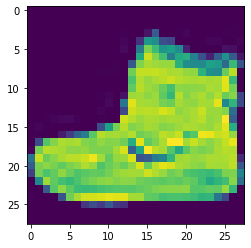

In [14]:
plt.imshow(x_train[0])

- 신발?

In [27]:
y_train[0]

9

- 신발이미지 = x, 신발임을 의미하는 숫자 9 = y

In [29]:
np.where(y_train == 9)  

(array([    0,    11,    15, ..., 59932, 59970, 59978]),)

- y==9인 다른 obs조사 

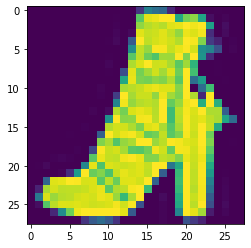

In [30]:
plt.imshow(x_train[11])

- obs0과 유사함

In [32]:
y_train[11]

9

### 데이터구조 

In [33]:
x_train.shape

(60000, 28, 28)

`-` $\bf{X}$: (n,28,28)인 tensor, 픽셀크기가 28$\times$28 인 이미지 

`-` ${\bf y}$: (n,)=길이가 1인 벡터, 이미지에 대응하는 라벨 (0~9까지의 숫자로 되어있다) 

## 예제1

### 데이터 정리 

`-` y=0,1에 대응하는 이미지만 정리하자. (우리가 배운건 로지스틱이니깐) 

In [44]:
y=y_train[(y_train == 0) | (y_train == 1)].reshape(-1,1)
X=x_train[(y_train == 0) | (y_train == 1)].reshape(-1,784)  #1차원으로 풀어버리자, 앞에 값은 모르니 -1로

In [38]:
28*28

784

In [45]:
yy= y_test[(y_test == 0) | (y_test == 1)].reshape(-1,1)
XX= x_test[(y_test == 0) | (y_test== 1)].reshape(-1,784)

In [46]:
X.shape,y.shape, XX.shape,yy.shape

((12000, 784), (12000, 1), (2000, 784), (2000, 1))

### 풀이1: 은닉층을 포함한 신경망  // epochs=100

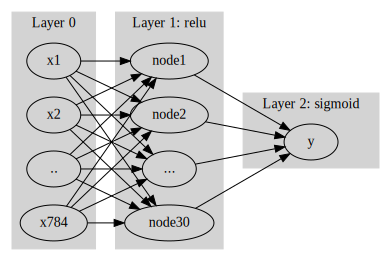

In [37]:
#collapse
gv('''
splines=line
subgraph cluster_1{
    style=filled;
    color=lightgrey;
    "x1"
    "x2"
    ".."
    "x784"
    label = "Layer 0"
}
subgraph cluster_2{
    style=filled;
    color=lightgrey;
    "x1" -> "node1"
    "x2" -> "node1"
    ".." -> "node1"
    
    "x784" -> "node1"
    "x1" -> "node2"
    "x2" -> "node2"
    ".." -> "node2"
    "x784" -> "node2"
    
    "x1" -> "..."
    "x2" -> "..."
    ".." -> "..."
    "x784" -> "..."

    "x1" -> "node30"
    "x2" -> "node30"
    ".." -> "node30"
    "x784" -> "node30"


    label = "Layer 1: relu"
}
subgraph cluster_3{
    style=filled;
    color=lightgrey;
    "node1" -> "y"
    "node2" -> "y"
    "..." -> "y"
    "node30" -> "y"
    label = "Layer 2: sigmoid"
}
''')

In [68]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='sgd',loss=tf.losses.binary_crossentropy)
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 0s 104ms/step - loss: 220.9145
Epoch 2/100
1/1 [==============================] - 0s 6ms/step - loss: 6799.9707
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7045
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7012
Epoch 5/100
1/1 [==============================] - 0s 3ms/step - loss: 0.7004
Epoch 6/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6997
Epoch 7/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6991
Epoch 8/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6985
Epoch 9/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6979
Epoch 10/100
1/1 [==============================] - 0s 3ms/step - loss: 0.6976
Epoch 11/100
1/1 [==============================] - 0s 6ms/step - loss: 0.6973
Epoch 12/100
1/1 [==============================] - 0s 5ms/step - loss: 0.6970
Epoch 13/100
1/1 [==============================] - 0s

In [69]:
net(X)  #yhat

<tf.Tensor: shape=(12000, 1), dtype=float32, numpy=
array([[0.49997538],
       [0.49997538],
       [0.49997538],
       ...,
       [0.49997538],
       [0.49997538],
       [0.49997538]], dtype=float32)>

In [70]:
np.mean((net(X)>0.5) == y.reshape(12000,1))  #정확률

0.5000833333333333

In [71]:
np.mean((net(XX)>0.5) == yy.reshape(2000,1))

0.5

- seed를 바꾸니까 정확률이 0.5로 떨어짐. 이런 경우는 local_min에 갖혀버린 것
- 그렇다고 잘 맞는 seed를 찾아야 하냐..그런 경우에는 모형이 안 좋은 것
- 다른 방법을 찾아보자!

### 풀이2: 옵티마이저 개선

In [72]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy)
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 0s 142ms/step - loss: 220.9145
Epoch 2/100
1/1 [==============================] - 0s 5ms/step - loss: 88.9451
Epoch 3/100
1/1 [==============================] - 0s 5ms/step - loss: 7.5897
Epoch 4/100
1/1 [==============================] - 0s 3ms/step - loss: 33.7528
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 40.2279
Epoch 6/100
1/1 [==============================] - 0s 5ms/step - loss: 28.9659
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 16.5115
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 9.4901
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 6.2021
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 5.2415
Epoch 11/100
1/1 [==============================] - 0s 5ms/step - loss: 5.5175
Epoch 12/100
1/1 [==============================] - 0s 6ms/step - loss: 6.5907
Epoch 13/100
1/1 [==============================] - 

In [74]:
np.mean((net(X)>0.5) == y.reshape(12000,1))

0.98125

In [75]:
np.mean((net(XX)>0.5) == yy.reshape(2000,1))

0.977

- adam으로 바꾸니 잘 나온다! 

### 풀이3: 컴파일시 metrics=['accuracy'] 추가
- 우리가 모델의 성능을 파악할 수 있는 통계량?들을 metrics라고 한다

In [76]:
#collapse_output
tf.random.set_seed(43055)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=100,batch_size=12000) 

Epoch 1/100
1/1 [==============================] - 0s 147ms/step - loss: 100.9425 - accuracy: 0.4988
Epoch 2/100
1/1 [==============================] - 0s 7ms/step - loss: 44.4432 - accuracy: 0.3740
Epoch 3/100
1/1 [==============================] - 0s 6ms/step - loss: 29.2324 - accuracy: 0.4321
Epoch 4/100
1/1 [==============================] - 0s 6ms/step - loss: 22.6913 - accuracy: 0.5399
Epoch 5/100
1/1 [==============================] - 0s 5ms/step - loss: 8.7736 - accuracy: 0.7321
Epoch 6/100
1/1 [==============================] - 0s 3ms/step - loss: 4.6409 - accuracy: 0.8516
Epoch 7/100
1/1 [==============================] - 0s 3ms/step - loss: 5.2642 - accuracy: 0.8711
Epoch 8/100
1/1 [==============================] - 0s 6ms/step - loss: 6.1992 - accuracy: 0.8772
Epoch 9/100
1/1 [==============================] - 0s 6ms/step - loss: 6.5540 - accuracy: 0.8845
Epoch 10/100
1/1 [==============================] - 0s 6ms/step - loss: 6.3451 - accuracy: 0.8953
Epoch 11/100
1/1 [====

In [77]:
net.evaluate(X,y)

375/375 [==============================] - 2s 5ms/step - loss: 0.1060 - accuracy: 0.9917


[0.10601804405450821, 0.9916666746139526]

In [78]:
net.evaluate(XX,yy)

63/63 [==============================] - 1s 7ms/step - loss: 0.2979 - accuracy: 0.9795


[0.2979137897491455, 0.9794999957084656]

### 풀이4: 확률적경사하강법 이용 // epochs=10

In [79]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=10,batch_size=1200) #batch size=1200 이면 iter=10번, epoch 100에서 10으로 감소 

Epoch 1/10
10/10 [==============================] - 0s 6ms/step - loss: 45.0335 - accuracy: 0.7220
Epoch 2/10
10/10 [==============================] - 0s 7ms/step - loss: 6.2030 - accuracy: 0.9016
Epoch 3/10
10/10 [==============================] - 0s 5ms/step - loss: 2.5029 - accuracy: 0.9590
Epoch 4/10
10/10 [==============================] - 0s 7ms/step - loss: 1.1528 - accuracy: 0.9697
Epoch 5/10
10/10 [==============================] - 0s 6ms/step - loss: 0.9529 - accuracy: 0.9703
Epoch 6/10
10/10 [==============================] - 0s 6ms/step - loss: 0.7179 - accuracy: 0.9773
Epoch 7/10
10/10 [==============================] - 0s 5ms/step - loss: 0.6386 - accuracy: 0.9786
Epoch 8/10
10/10 [==============================] - 0s 6ms/step - loss: 0.5794 - accuracy: 0.9793
Epoch 9/10
10/10 [==============================] - 0s 6ms/step - loss: 0.5321 - accuracy: 0.9810
Epoch 10/10
10/10 [==============================] - 0s 7ms/step - loss: 0.5050 - accuracy: 0.9812


In [80]:
net.evaluate(X,y)

375/375 [==============================] - 2s 5ms/step - loss: 0.4874 - accuracy: 0.9813


[0.4874187409877777, 0.981333315372467]

In [81]:
net.evaluate(XX,yy)

63/63 [==============================] - 1s 8ms/step - loss: 0.4362 - accuracy: 0.9790


[0.4361507296562195, 0.9789999723434448]

- 한 번 epoch에서 iter=update가 10번 진행되니까 accuracy가 증가한 것을 볼 수 있음

In [84]:
#collapse_output
tf.random.set_seed(43052)
net = tf.keras.Sequential() 
net.add(tf.keras.layers.Dense(30,activation='relu'))
net.add(tf.keras.layers.Dense(1,activation='sigmoid'))
net.compile(optimizer='adam',loss=tf.losses.binary_crossentropy,metrics=['accuracy'])
net.fit(X,y,epochs=10,batch_size=120)

Epoch 1/10
100/100 [==============================] - 1s 5ms/step - loss: 5.6482 - accuracy: 0.9418
Epoch 2/10
100/100 [==============================] - 0s 5ms/step - loss: 0.5070 - accuracy: 0.9792
Epoch 3/10
100/100 [==============================] - 1s 5ms/step - loss: 0.3774 - accuracy: 0.9820
Epoch 4/10
100/100 [==============================] - 0s 5ms/step - loss: 0.3497 - accuracy: 0.9829
Epoch 5/10
100/100 [==============================] - 0s 5ms/step - loss: 0.2401 - accuracy: 0.9855
Epoch 6/10
100/100 [==============================] - 0s 5ms/step - loss: 0.2218 - accuracy: 0.9868
Epoch 7/10
100/100 [==============================] - 0s 5ms/step - loss: 0.1802 - accuracy: 0.9891
Epoch 8/10
100/100 [==============================] - 1s 5ms/step - loss: 0.1690 - accuracy: 0.9886
Epoch 9/10
100/100 [==============================] - 1s 5ms/step - loss: 0.1111 - accuracy: 0.9908
Epoch 10/10
100/100 [==============================] - 1s 5ms/step - loss: 0.1261 - accuracy: 0.9902

In [85]:
net.evaluate(X,y)

375/375 [==============================] - 2s 5ms/step - loss: 0.0745 - accuracy: 0.9937


[0.07449778914451599, 0.9936666488647461]

In [86]:
net.evaluate(XX,yy)

63/63 [==============================] - 1s 8ms/step - loss: 0.2422 - accuracy: 0.9860


[0.24218188226222992, 0.9860000014305115]

- 관습적으로 batch size는 메모리를 아끼는 방법이니까 그 용량에 맞춰서 (ex.256기가 등등..) 이에 맞춰 올림
- 다른 수로 올려도 상관없음. 약간 메모리를 낭비하는..?